In [1]:
#inventory management + v5

In [2]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta

import matplotlib.pyplot as plot
import networkx as nx

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [3]:
#id directories
data_dir = os.getcwd().replace('/model', '/data')
results_dir = os.getcwd().replace('/model', '/results')

In [4]:
#define sets
K = 1
I = 3
T = 10

#define parameters
r_k_dict = {
    1 : 1
}

q_k_i_dict = {
    tuple([1,1]) : 3,
    tuple([1,2]): 2,
    tuple([1,3]): 2
}

z_k_i_init_dict = {
    tuple([1,1]) : 2,
    tuple([1,2]) : 1,
    tuple([1,3]) : 3
}

f_k_i_tDiff_dict = {
    tuple([1,1,0]) : 0.9,
    tuple([1,2,0]) : .1,
    tuple([1,3,0]) : .2,
    tuple([1,1,1]) : .1,
    tuple([1,2,1]) : 0,
    tuple([1,3,1]) : 0,
    tuple([1,1,2]) : 0,
    tuple([1,2,2]) : 0,
    tuple([1,3,2]) : .2,
    tuple([1,1,3]) : 0,
    tuple([1,2,3]) : .2,
    tuple([1,3,3]) : .3,
    tuple([1,1,4]) : 0,
    tuple([1,2,4]) : .2,
    tuple([1,3,4]) : .1,
    tuple([1,1,5]) : 0,
    tuple([1,2,5]) : .1,
    tuple([1,3,5]) : .1,
    tuple([1,1,6]) : 0,
    tuple([1,2,6]) : .1,
    tuple([1,3,6]) : .1,
    tuple([1,1,7]) : 0,
    tuple([1,2,7]) : .1,
    tuple([1,3,7]) : 0,
    tuple([1,1,8]) : 0,
    tuple([1,2,8]) : 0,
    tuple([1,3,8]) : 0,
    tuple([1,1,9]) : 0,
    tuple([1,2,9]) : 0,
    tuple([1,3,9]) : 0,
    tuple([1,1,10]) : 0,
    tuple([1,2,10]) : 0,
    tuple([1,3,10]) : 0
}


o_k_i_t_dict = {
    tuple([1,1,1]) : 3,
    tuple([1,2,1]) : 0,
    tuple([1,3,1]) : 0,
    tuple([1,1,2]) : 0,
    tuple([1,2,2]) : 2,
    tuple([1,3,2]) : 0,
    tuple([1,1,3]) : 0,
    tuple([1,2,3]) : 1,
    tuple([1,3,3]) : 0,
    tuple([1,1,4]) : 0,
    tuple([1,2,4]) : 3,
    tuple([1,3,4]) : 0,
    tuple([1,1,5]) : 3,
    tuple([1,2,5]) : 0,
    tuple([1,3,5]) : 0,
    tuple([1,1,6]) : 0,
    tuple([1,2,6]) : 0,
    tuple([1,3,6]) : 0,
    tuple([1,1,7]) : 0,
    tuple([1,2,7]) : 0,
    tuple([1,3,7]) : 0,
    tuple([1,1,8]) : 0,
    tuple([1,2,8]) : 0,
    tuple([1,3,8]) : 0,
    tuple([1,1,9]) : 0,
    tuple([1,2,9]) : 0,
    tuple([1,3,9]) : 0,
    tuple([1,1,10]) : 0,
    tuple([1,2,10]) : 0,
    tuple([1,3,10]) : 0
}



alpha_k_dict = {
    1 : 0
}

D_k_t_dict_mu_sd = {
    tuple([1,1]) : [2, 1],
    tuple([1,2]) : [2, 1],
    tuple([1,3]) : [10, 1],
    tuple([1,4]) : [2, 1],
    tuple([1,5]) : [20, 1],
    tuple([1,6]) : [2, 1],
    tuple([1,7]) : [1, .5],
    tuple([1,8]) : [2, 1],
    tuple([1,9]) : [10, 2],
    tuple([1,10]) : [2, 1]
}

s_k_dict = {
    1 : .5
}

h = 200

c_k_i_dict = {
    tuple([1,1]) : 1,
    tuple([1,2]) : .8,
    tuple([1,3]) : .5
}

b = 100

CAP_i_t_dict_mu_sd = {
    tuple([1,1]) : [10, 1],
    tuple([1,2]) : [10, 1],
    tuple([1,3]) : [10, 1],
    tuple([1,4]) : [10, 1],
    tuple([1,5]) : [10, 1],
    tuple([1,6]) : [10, 1],
    tuple([1,7]) : [10, 1],
    tuple([1,8]) : [10, 1],
    tuple([1,9]) : [10, 1],
    tuple([1,10]) : [10, 1],
    tuple([2,1]) : [8, 1],
    tuple([2,2]) : [8, 1],
    tuple([2,3]) : [8, 1],
    tuple([2,4]) : [8, 1],
    tuple([2,5]) : [8, 1],
    tuple([2,6]) : [8, 1],
    tuple([2,7]) : [8, 1],
    tuple([2,8]) : [8, 1],
    tuple([2,9]) : [8, 1],
    tuple([2,10]) : [20, 1],
    tuple([3,1]) : [10, 1],
    tuple([3,2]) : [20, 1],
    tuple([3,3]) : [5, 1],
    tuple([3,4]) : [5, 1],
    tuple([3,5]) : [5, 1],
    tuple([3,6]) : [30, 1],
    tuple([3,7]) : [5, .5],
    tuple([3,8]) : [5, 1],
    tuple([3,9]) : [5, 2],
    tuple([3,10]) : [5, 1]
}

In [5]:
model = ConcreteModel()

#####define sets#######
model.K = Set(initialize = range(1,K+1))
model.I = Set(initialize = range(1,I+1))
model.T = Set(initialize = range(1,T+1))
#model.T_beg = Set(initialize = range(0,T+1))

####initialize parameters####

#essentiality rank param
def rank_param_initialize(model, k):
    return(r_k_dict.get(k))

model.r_k = Param(model.K, initialize = rank_param_initialize)

#quality param
def quality_param_initialize(model, k, i):
    return(q_k_i_dict.get(tuple([k,i])))

model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

#incoming orders
def incoming_orders_initialize(model, k, i, t):
    return(o_k_i_t_dict.get(tuple([k,i,t])))

model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

#beggining inventory
def beg_inv_param_initialize(model, k, i):
    return(z_k_i_init_dict.get(tuple([k,i])))

model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

def delay_dist_param_initialize(model, k, i, t):
    return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

model.f_k_i_tDiff = Param(model.K, model.I, model.T, initialize = delay_dist_param_initialize)

def unfulfilled_demand_param_initialize(model, k):
    return(alpha_k_dict.get(k))

model.alpha_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

#assume preparing for one sd above the mean
def mu_plus_sigma_demand_param_initialize(model, k, t):
    return(sum(D_k_t_dict_mu_sd.get(tuple([k,t]))))

model.d_k_t = Param(model.K, model.T, initialize = mu_plus_sigma_demand_param_initialize)

def item_size_param_initialize(model, k):
    return(s_k_dict.get(k))

model.s_k = Param(model.K, initialize = item_size_param_initialize)

def warehouse_cap_param_initialize(model):
    return(h)

model.h = Param(initialize = h)

def cost_param_initialize(model, k, i):
    return(c_k_i_dict.get(tuple([k,i])))

model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

def budget_param_initialize(model):
    return(b)

model.b = Param(initialize = budget_param_initialize)

def supplier_cap_param_initialize(model, i, t):
    return(sum(CAP_i_t_dict_mu_sd.get(tuple([i,t]))))

model.cap = Param(model.I, model.T, initialize = supplier_cap_param_initialize)

####initialize variables####
model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
model.alpha_k_t = Var(model.K, model.T, within = NonNegativeReals)
model.beta_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)

In [6]:
#def initialize_objective(model):
model.Objective = Objective(expr = 
                            (sum(model.r_k[k]*sum((1/t)*model.q_k_i[k,i]*model.beta_k_i_t[k,i,t] 
                                                  for i in model.I for t in model.T) for k in model.K)),
                            sense = maximize)

In [7]:
def beggining_inventory_constraint_initialize(model, k, i):
    return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])
    
model.beggining_inventory_constraint = Constraint(model.K, model.I, 
                                                  rule = beggining_inventory_constraint_initialize)

In [8]:
def initalize_unsatisfied_demand_constraint_initialize(model, k):
    return(model.alpha_k_t[k,1] == model.alpha_k_intialize[k])

model.initalize_unsatisfied_demand_constraint_initialize = \
Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

In [9]:
def incoming_orders_constraint_initialize(model, k, i, t):
    return(model.y_k_i_t[k,i,t] - sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] for t_ordered_time in range(1,t)) - 
           model.o_k_i_t[k,i,t] == 0)

model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                               rule = incoming_orders_constraint_initialize)

In [10]:
def calculate_available_inventory_constraint_initialize(model, k, i, t):
    if (t > 1):
        return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + model.beta_k_i_t[k,i,t-1] == 0)
    else:
        return(Constraint.Skip)
    
model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                            rule = 
                                                            calculate_available_inventory_constraint_initialize)

In [11]:
def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
    return(model.beta_k_i_t[k,i,t] - model.z_k_i_t[k,i,t] <= 0)

model.cannot_fulfill_more_than_available_constraint = \
Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

In [12]:
def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
    if t > 1:
        return(model.alpha_k_t[k,t] - model.alpha_k_t[k,t-1] + sum(model.beta_k_i_t[k,i,t] for i in model.I) == \
               model.d_k_t[k,t])
    else:
        return(Constraint.Skip)

model.calculate_unsatisfied_demand_constraint = \
Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)

In [13]:
def warehouse_capacity_constraint_initialize(model, t):
    return(sum(model.s_k[k]*model.z_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.h)

model.warehouse_capacity_constraint = \
Constraint(model.T, rule = warehouse_capacity_constraint_initialize)

In [14]:
def budget_constraint_initialize(model, t):
    return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.b)

model.budget_constraint = \
Constraint(model.T, rule = budget_constraint_initialize)

In [15]:
def supplier_constraint_initialize(model, i, t):
    return(sum(model.x_k_i_t[k,i,t] for k in model.K) <= model.cap[i,t])

model.supplier_constraint = \
Constraint(model.I, model.T, rule = supplier_constraint_initialize)

In [16]:
opt = SolverFactory('gurobi_persistent')
opt.set_instance(model)
opt.solve(model)

Using license file /Users/chelseagreene/gurobi.lic
Academic license - for non-commercial use only


{'Problem': [{'Name': 'unknown', 'Lower bound': 40.28424603174604, 'Upper bound': 40.28424603174604, 'Number of objectives': 1, 'Number of constraints': 150, 'Number of variables': 130, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 130, 'Number of nonzeros': 401, 'Sense': -1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.01', 'Status': 'ok', 'Wallclock time': 0.005072116851806641, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [17]:
#extract ordering df
ordered_df = pd.DataFrame(list(model.x_k_i_t.extract_values().items()),columns = ['sets','units_to_order'])
ordered_df.loc[:,'item_type']=ordered_df.sets.map(lambda x:x[0])
ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[1])
ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[2])

In [18]:
#extract expected arrivals df
recieved_df = pd.DataFrame(list(model.y_k_i_t.extract_values().items()),columns = ['sets','expected_units_recieved'])
recieved_df.loc[:,'item_type']=recieved_df.sets.map(lambda x:x[0])
recieved_df.loc[:,'supplier']=recieved_df.sets.map(lambda x:x[1])
recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[2])

In [19]:
#extract expected fulfilled df
fulfilled_df = pd.DataFrame(list(model.beta_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])

In [20]:
#extract expected available df
available_df = pd.DataFrame(list(model.beta_k_i_t.extract_values().items()),columns = ['sets','units_available'])
available_df.loc[:,'item_type']=available_df.sets.map(lambda x:x[0])
available_df.loc[:,'supplier']=available_df.sets.map(lambda x:x[1])
available_df.loc[:,'time_interval']=available_df.sets.map(lambda x:x[2])

In [21]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.alpha_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

In [22]:
demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()), columns = ['sets', 'demand_in_units'])
demand_df.loc[:,'item_type']=demand_df.sets.map(lambda x:x[0])
demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])

In [23]:
ordered_and_recieved_df = ordered_df[['item_type', 'supplier', 'time_interval', 'sets']]
ordered_and_recieved_df = ordered_and_recieved_df.merge(recieved_df[['sets', 'expected_units_recieved']],
                                                        on='sets', how='left')
ordered_and_recieved_df = ordered_and_recieved_df.merge(ordered_df[['sets', 'units_to_order']],
                                                        on='sets', how='left')

ordered_and_recieved_df = ordered_and_recieved_df[['item_type', 'supplier', 
                                                   'time_interval','units_to_order', 
                                                   'expected_units_recieved']]

ordered_and_recieved_df['units_to_order'] = (round(ordered_and_recieved_df['units_to_order'])).astype(int)
ordered_and_recieved_df['expected_units_recieved'] = (round(ordered_and_recieved_df['expected_units_recieved'])).astype(int)

In [24]:
os.chdir(results_dir)
ordered_and_recieved_df.to_csv('ordering_and_recieving_schedule.csv')

In [25]:
fulfilled_df.head()

,sets,units_fulfilled,item_type,supplier,time_interval
0,"(1, 1, 1)",2.0,1,1,1
1,"(1, 1, 2)",3.0,1,1,2
2,"(1, 1, 3)",1.1,1,1,3
3,"(1, 1, 4)",1.1,1,1,4
4,"(1, 1, 5)",1.1,1,1,5


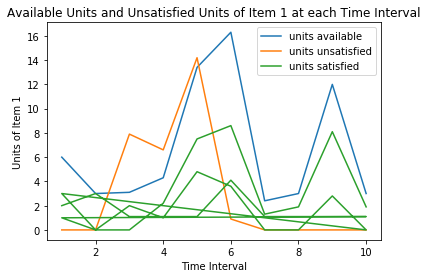

In [28]:
available_overtime_df = available_df.groupby(['time_interval'])["units_available"].sum().reset_index()
plot.plot(available_overtime_df['time_interval'], available_overtime_df['units_available'], label='units available') #available
plot.plot(unsatisfied_df['time_interval'], unsatisfied_df['units_unsatisfied'], label='units unsatisfied') #orange
plot.plot(fulfilled_df['time_interval'], fulfilled_df['units_fulfilled'], label='units satisfied') #orange

plot.xlabel('Time Interval')
plot.ylabel('Units of Item 1')
plot.title('Available Units and Unsatisfied Units of Item 1 at each Time Interval')
plot.legend()
plot.savefig('available_and_unsatisfied_lineplot.jpg')

In [ ]:
pos_dict_all = {}
label_dict_all = {}
color_dict_all = {}
G_dict_all = {}

In [ ]:
for i in range(1,I+1):
    G=nx.Graph()
    label_dict = {}
    color_map = []
    
    global ordered_df
    global recieved_df
    
    time_coordinates = range(1,T+1)
    ordered_amount_coordinates = np.array(ordered_df[(ordered_df['supplier'] == i)]['units_to_order'])
    recieved_amount_coordinates = np.array(recieved_df[(recieved_df['supplier'] == i)]['expected_units_recieved'])

    for t in range(T):
        ordered_amount = ordered_amount_coordinates[t]
        recieved_amount = recieved_amount_coordinates[t]

        if (ordered_amount > 0):
            name = str(t) + 'planned units to order' + str(ordered_amount)
            G.add_node(name, pos = (t+1,1))
            label_dict[name] = round(ordered_amount).astype(int)
            color_map.append('blue')

        if (recieved_amount > 0):
            name = str(t) + 'expected number of units recieved' + str(recieved_amount)
            G.add_node(name, pos = (t+1,2))
            label_dict[name] = round(recieved_amount).astype(int)
            color_map.append('green')

    pos=nx.get_node_attributes(G,'pos')
    label_dict_all['supplier' + str(i)] = label_dict
    color_dict_all['supplier' + str(i)] = color_map
    pos_dict_all['supplier' + str(i)] = pos
    G_dict_all['supplier' + str(i)] = G

In [ ]:
for i in range(1, I+1):

    fig, ax = plot.subplots()
    nx.draw(G_dict_all.get('supplier' + str(i)),
            pos_dict_all.get('supplier' + str(i)), 
            labels=label_dict_all.get('supplier' + str(i)), 
            node_size=600, font_size=16, with_labels = True, 
            node_color=color_dict_all.get('supplier' + str(i)), 
            ax = ax)
    ax.set_xlabel('Time Interval Ordered and Recieved')
    ax.set_ylabel('Place Order             Recieved Order')
    ax.set(ylim=(.5, 2.5))
    ax.set_title('Time Interval Order is Placed and Recieved \n for Supplier '+ str(i)+' for Item 1')
    ax.tick_params(left=True, bottom=True, labelleft=False, labelbottom=True)
    limits=plot.axis('on')
    plot.savefig('Item_1_Supplier' + str(i)+'.jpg')